<a href="https://colab.research.google.com/github/rakesh4334/Smart-Disease-Predictor/blob/main/malaria.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
!mkdir ~/.kaggle
!echo '{"username": "chandrarakesh", "key": "8e771171b831b7c36c7d14949221f942" }' > ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [24]:
!chmod 600 /root/.kaggle/kaggle.json

In [25]:
!kaggle config set -k YOUR_API_KEY

usage: kaggle config set [-h] -n NAME -v VALUE
kaggle config set: error: the following arguments are required: -n/--name, -v/--value


In [26]:
!kaggle datasets download -d iarunava/cell-images-for-detecting-malaria

100% 675M/675M [00:33<00:00, 20.8MB/s]
100% 675M/675M [00:33<00:00, 21.1MB/s]


In [27]:
import zipfile

z= zipfile.ZipFile('cell-images-for-detecting-malaria.zip')
z.extractall()

In [28]:
import os, shutil
import random
import numpy as np
import pandas as pd
import itertools
from tqdm import tqdm, tqdm_notebook
import cv2
from scipy import stats
from sklearn.metrics import confusion_matrix, roc_curve,auc, classification_report, precision_score, recall_score
from sklearn.linear_model import LinearRegression

import skimage
import skimage.segmentation
import copy
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.image as mpimg

%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

print(tf.__version__)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Input, Flatten, Dense, MaxPooling2D, Conv2D, Dropout
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.optimizers import SGD, RMSprop, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications.imagenet_utils import decode_predictions

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Found GPU at: /device:GPU:0
2.15.0


In [29]:
original_dataset_parasitized = os.path.join('cell_images/cell_images', 'Parasitized/')
original_dataset_uninfected = os.path.join('cell_images/cell_images', 'Uninfected/')

In [30]:
# Create a base dir
if not os.path.isdir('healthy_and_infected'):
    base_dir = 'healthy_and_infected'
    os.mkdir(base_dir)

In [31]:
# Make train, valid and test directories
#train
if not os.path.isdir('healthy_and_infected/train'):
    train_dir = os.path.join(base_dir, 'train')
    os.mkdir(train_dir)
#valid
if not os.path.isdir('healthy_and_infected/valid'):
    valid_dir = os.path.join(base_dir, 'valid')
    os.mkdir(valid_dir)
#test
if not os.path.isdir('healthy_and_infected/test'):
    test_dir = os.path.join(base_dir, 'test')
    os.mkdir(test_dir)

In [32]:
# Make directories for infected images in each of the train, valid and test directories
if not os.path.isdir('healthy_and_infected/train/inf'):
    infected_trn_dir = os.path.join(train_dir, 'inf')
    os.mkdir(infected_trn_dir)

if not os.path.isdir('healthy_and_infected/valid/inf'):
    infected_valid_dir = os.path.join(valid_dir, 'inf')
    os.mkdir(infected_valid_dir)

if not os.path.isdir('healthy_and_infected/test/inf'):
    infected_test_dir = os.path.join(test_dir, 'inf')
    os.mkdir(infected_test_dir)

In [33]:
# Make directories for healthy images in each of the train, valid and test directories
if not os.path.isdir('healthy_and_infected/train/healthy'):
    healthy_trn_dir = os.path.join(train_dir, 'healthy')
    os.mkdir(healthy_trn_dir)

if not os.path.isdir('healthy_and_infected/valid/healthy'):
    healthy_valid_dir = os.path.join(valid_dir, 'healthy')
    os.mkdir(healthy_valid_dir)

if not os.path.isdir('healthy_and_infected/test/healthy'):
    healthy_test_dir = os.path.join(test_dir, 'healthy')
    os.mkdir(healthy_test_dir)

In [34]:
files1 = os.listdir('cell_images/cell_images/Parasitized/')
fnames1 = []
for i in range(13779):
    fnames1.append(files1[i])

if 'Thumbs.db' in fnames1:
    os.remove('cell_images/cell_images/Parasitized/Thumbs.db')

files2 = os.listdir('cell_images/cell_images/Uninfected/')
fnames2 = []
for i in range(13779):
    fnames2.append(files2[i])

if 'Thumbs.db' in fnames2:
    os.remove('cell_images/cell_images/Uninfected/Thumbs.db')

In [35]:
files = os.listdir('cell_images/cell_images/Parasitized/')
fnames = []
for i in range(11023):
    fnames.append(files[i])

for fname in fnames:
    src = os.path.join(original_dataset_parasitized, fname)
    dst = os.path.join(infected_trn_dir, fname)
    shutil.copyfile(src,dst)

In [36]:
files = os.listdir('cell_images/cell_images/Parasitized/')
fnames = []
for i in range(11023, 12401):
    fnames.append(files[i])

for fname in fnames:
    src = os.path.join(original_dataset_parasitized, fname)
    dst = os.path.join(infected_test_dir, fname)
    shutil.copyfile(src,dst)

In [37]:
files = os.listdir('cell_images/cell_images/Parasitized/')
fnames = []
for i in range(12401, 13779):
    fnames.append(files[i])

for fname in fnames:
    src = os.path.join(original_dataset_parasitized, fname)
    dst = os.path.join(infected_valid_dir, fname)
    shutil.copyfile(src,dst)

In [38]:
files = os.listdir('cell_images/cell_images/Uninfected/')
fnames = []
for i in range(11023):
    fnames.append(files[i])

for fname in fnames:
    src = os.path.join(original_dataset_uninfected, fname)
    dst = os.path.join(healthy_trn_dir, fname)
    shutil.copyfile(src,dst)

In [39]:
files = os.listdir('cell_images/cell_images/Uninfected/')
fnames = []
for i in range(11023, 12401):
    fnames.append(files[i])

for fname in fnames:
    src = os.path.join(original_dataset_uninfected, fname)
    dst = os.path.join(healthy_test_dir, fname)
    shutil.copyfile(src,dst)

In [40]:
files = os.listdir('cell_images/cell_images/Uninfected/')
fnames = []
for i in range(12401, 13779):
    fnames.append(files[i])

for fname in fnames:
    src = os.path.join(original_dataset_uninfected, fname)
    dst = os.path.join(healthy_valid_dir, fname)
    shutil.copyfile(src,dst)

In [42]:
print(" {} Infected training images.".format(len(os.listdir(infected_trn_dir))))
print(" {} Uninfected training images.".format(len(os.listdir(healthy_trn_dir))))
print(" {} Infected valid images.".format(len(os.listdir(infected_valid_dir))))
print(" {} Uninfected valid images.".format(len(os.listdir(healthy_valid_dir))))
print(" {} Infected testing images.".format(len(os.listdir(infected_test_dir))))
print(" {} Uninfected testing images.".format(len(os.listdir(healthy_test_dir))))

 11023 Infected training images.
 11023 Uninfected training images.
 1378 Infected valid images.
 1378 Uninfected valid images.
 1378 Infected testing images.
 1378 Uninfected testing images.


# Exploratory Data Analysis

In [43]:
# Train
infected_trn_fpaths = [os.path.join(infected_trn_dir, fpath) for fpath in os.listdir(infected_trn_dir)]
healthy_trn_fpaths = [os.path.join(healthy_trn_dir, fpath) for fpath in os.listdir(healthy_trn_dir)]

# Valid
infected_valid_fpaths = [os.path.join(infected_valid_dir, fpath) for fpath in os.listdir(infected_valid_dir)]
healthy_valid_fpaths = [os.path.join(healthy_valid_dir, fpath) for fpath in os.listdir(healthy_valid_dir)]

# Test
infected_test_fpaths = [os.path.join(infected_test_dir, fpath) for fpath in os.listdir(infected_test_dir)]
healthy_test_fpaths = [os.path.join(healthy_test_dir, fpath) for fpath in os.listdir(healthy_test_dir)]

In [44]:
def get_img_shape(idx, img, total_num_images):

    if idx%2000 ==0 or idx == (total_num_images-1):
        print("working on img {}".format(idx))
    return cv2.imread(img).shape

data_inp = [(idx, img, len(infected_trn_fpaths + healthy_trn_fpaths)) for idx, img in enumerate(infected_trn_fpaths + healthy_trn_fpaths)]

train_img_dims_map = list(map(get_img_shape, [input[0] for input in data_inp],
    [input[1] for input in data_inp],
    [input[2] for input in data_inp]))

working on img 0
working on img 2000
working on img 4000
working on img 6000
working on img 8000
working on img 10000
working on img 12000
working on img 14000
working on img 16000
working on img 18000
working on img 20000
working on img 22000
working on img 22045


In [45]:
print('Min Dimensions:           {}'.format(np.min(train_img_dims_map, axis=0)))
print('Avg Dimensions:           {}'.format(np.mean(train_img_dims_map, axis=0)))
print('Median Dimensions:        {}'.format(np.median(train_img_dims_map, axis=0)))
print('Most Frequent Dimensions: {}'.format(stats.mode(train_img_dims_map, axis=0)[0]))
print('Max Dimensions:           {}'.format(np.max(train_img_dims_map, axis=0)))

Min Dimensions:           [40 46  3]
Avg Dimensions:           [132.95427742 132.44683843   3.        ]
Median Dimensions:        [130. 130.   3.]
Most Frequent Dimensions: [130 130   3]
Max Dimensions:           [385 394   3]


In [46]:
infected_trn_samples = random.sample(infected_trn_fpaths, 5)
healthy_trn_samples = random.sample(healthy_trn_fpaths, 5)

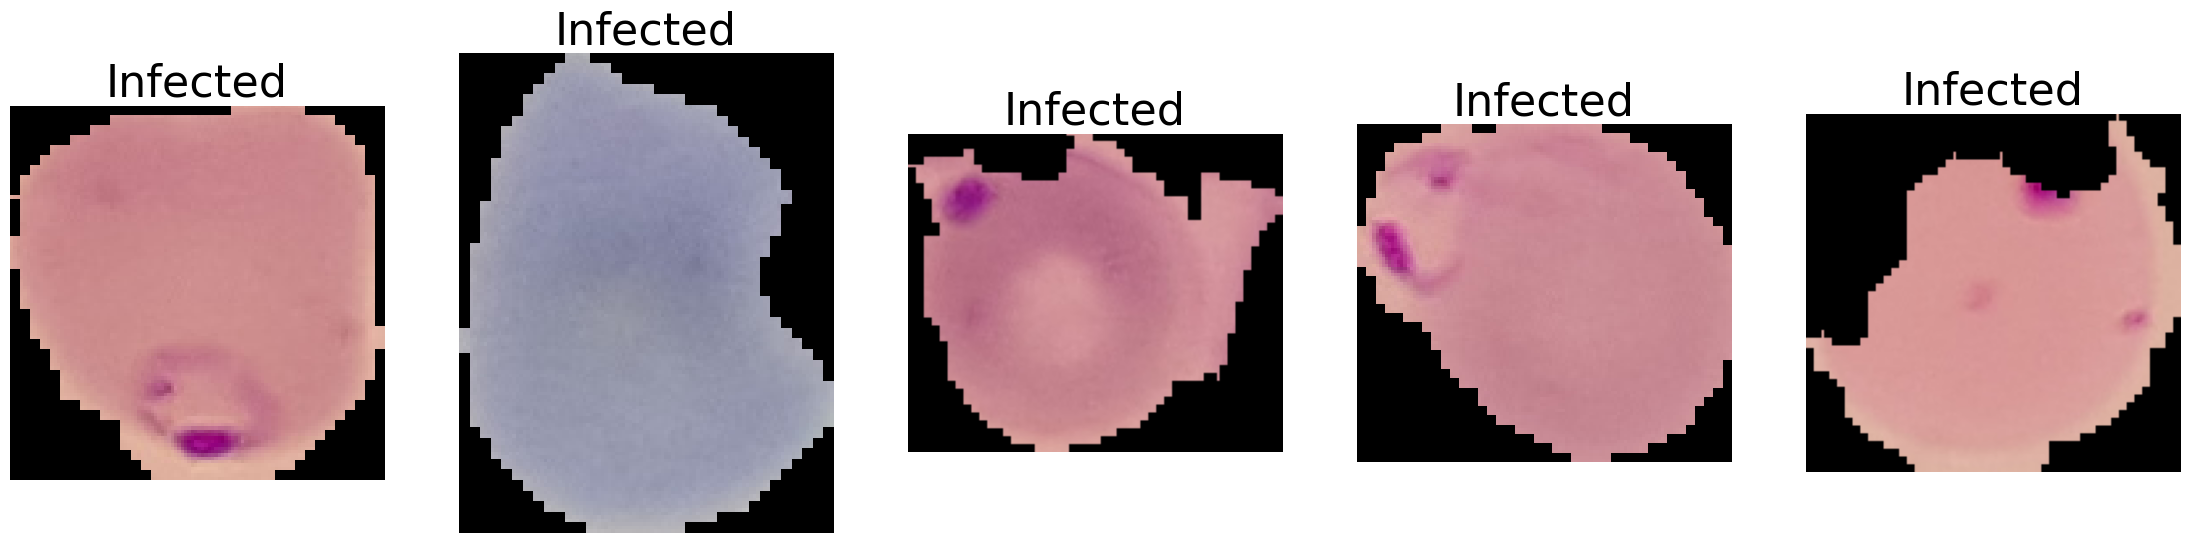

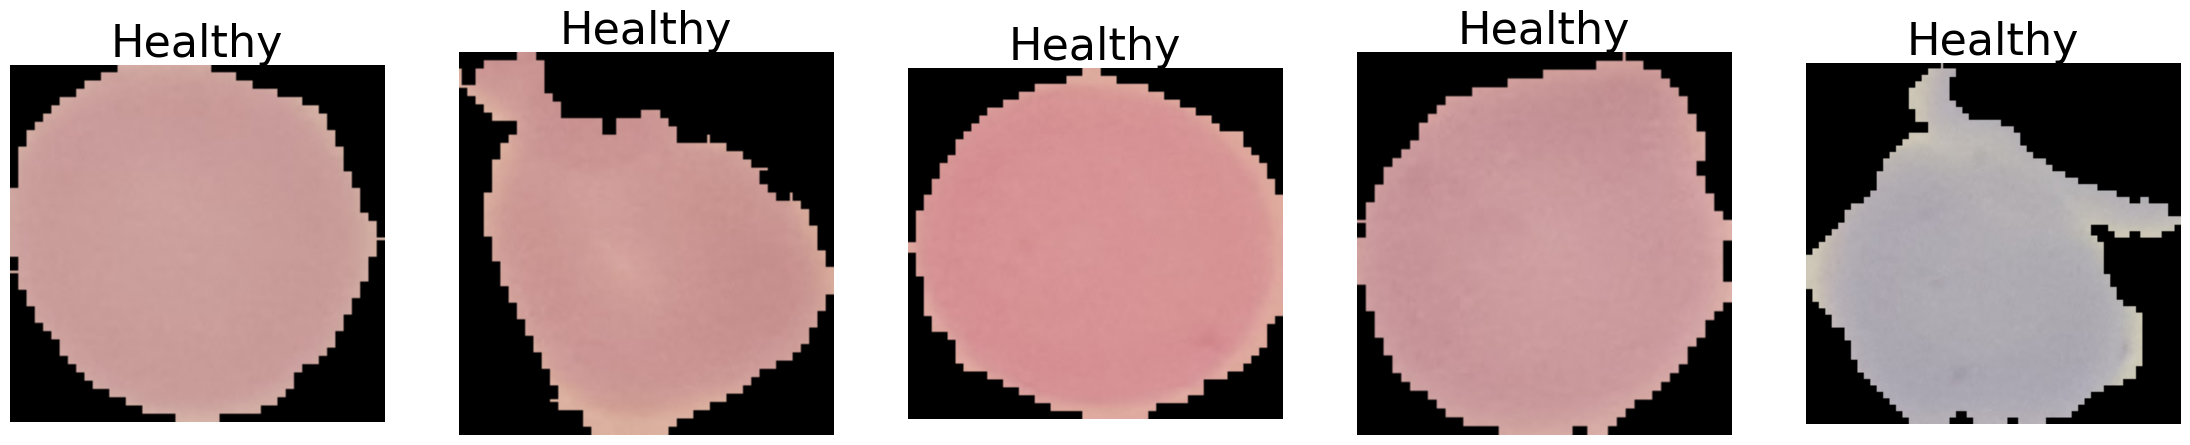

In [51]:
fig =plt.figure(figsize=(28,14))
columns=5
rows=1
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(mpimg.imread(infected_trn_samples[i-1]))
    plt.axis('off')
    plt.title('Infected', fontsize=32)
plt.show()


fig =plt.figure(figsize=(28,14))
columns=5
rows=1
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(mpimg.imread(healthy_trn_samples[i-1]))
    plt.axis('off')
    plt.title('Healthy', fontsize=32)
plt.savefig("outputs/malaria_cell_images.jpeg", format='jpeg', dpi=400, bbox_inches='tight')
plt.show()

# Data augmentation and resizing images

In [52]:
train_datagen = ImageDataGenerator(rescale=1./255.,
                                   horizontal_flip=0.4,
                                   vertical_flip=0.4,
                                   rotation_range=40,
                                   shear_range=0.2,
                                   width_shift_range=0.4,
                                   height_shift_range=0.4,
                                   fill_mode='nearest')
valid_datagen = ImageDataGenerator(rescale=1.0/255.)
test_datagen = ImageDataGenerator(rescale=1.0/255.)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=32,
                                                    target_size=(128,128),
                                                    class_mode='categorical',
                                                    shuffle=True,
                                                    seed=42,
                                                    color_mode='rgb')

valid_generator = valid_datagen.flow_from_directory(valid_dir,
                                                    batch_size=32,
                                                    target_size=(128, 128),
                                                    class_mode='categorical',
                                                    shuffle=True,
                                                    seed=42,
                                                    color_mode='rgb')

class_labels = train_generator.class_indices
class_names = {value:key for (key, value) in class_labels.items()}

Found 22046 images belonging to 2 classes.
Found 2756 images belonging to 2 classes.


In [53]:
class_labels, class_names

({'healthy': 0, 'inf': 1}, {0: 'healthy', 1: 'inf'})

# Transfer Learning - VGG19 CNN Architecture

In [55]:
# Instantiate VGG19 model with weights from Imagenet without the calssifier at the top
base_model = VGG19(input_shape = (128,128,3),
                   include_top = False,
                   weights = 'imagenet')
# Freeze the ConvNet to avoid weight updates
for layer in base_model.layers:
    layer.trainable=False

x = base_model.output
flat=Flatten()(x)

# Add a classifier -  a fully connected dense layers
class_1 = Dense(4608, activation='relu')(flat)
drop_out = Dropout(0.2)(class_1)
class_2 = Dense(1152, activation='relu')(drop_out)
output = Dense(2, activation='softmax')(class_2)

# Bake a model
model_01 = Model(base_model.inputs, output)
model_01.summary()

# Call backs
filepath = 'models/malaria.h5'
es = EarlyStopping(monitor='val_loss', verbose=1, mode='min', patience=4)
cp = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True,
                     save_weights_only=False, mode='auto', save_freq='epoch')
lrr = ReduceLROnPlateau(monitor='val_accuracy',patience=3,verbose=1,factor=0.5,min_lr=0.0001)

# Define an optimizer
sgd = tf.keras.optimizers.legacy.SGD(learning_rate=.0001, decay=1e-6, momentum=0.9, nesterov=True)

# Compile the model
model_01.compile(loss="categorical_crossentropy", optimizer=sgd, metrics=["accuracy"])

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0   

In [56]:
# Fit the model on the training set and train for 10 epochs
history_01 = model_01.fit(train_generator,
                          steps_per_epoch=50,
                          epochs=10,
                          callbacks = [es, cp, lrr],
                          validation_data = valid_generator)

Epoch 1/10
50/50 [==============================] - ETA: 0s - loss: 0.7238 - accuracy: 0.5431
Epoch 1: val_loss improved from inf to 0.67221, saving model to models/malaria.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


50/50 [==============================] - 27s 370ms/step - loss: 0.7238 - accuracy: 0.5431 - val_loss: 0.6722 - val_accuracy: 0.5657 - lr: 1.0000e-04
Epoch 2/10
50/50 [==============================] - ETA: 0s - loss: 0.6367 - accuracy: 0.6375
Epoch 2: val_loss improved from 0.67221 to 0.59810, saving model to models/malaria.h5
50/50 [==============================] - 18s 354ms/step - loss: 0.6367 - accuracy: 0.6375 - val_loss: 0.5981 - val_accuracy: 0.7747 - lr: 1.0000e-04
Epoch 3/10
50/50 [==============================] - ETA: 0s - loss: 0.6126 - accuracy: 0.6725
Epoch 3: val_loss improved from 0.59810 to 0.55850, saving model to models/malaria.h5
50/50 [==============================] - 18s 346ms/step - loss: 0.6126 - accuracy: 0.6725 - val_loss: 0.5585 - val_accuracy: 0.7801 - lr: 1.0000e-04
Epoch 4/10
50/50 [==============================] - ETA: 0s - loss: 0.5866 - accuracy: 0.6800
Epoch 4: val_loss improved from 0.55850 to 0.53186, saving model to models/malaria.h5
50/50 [======

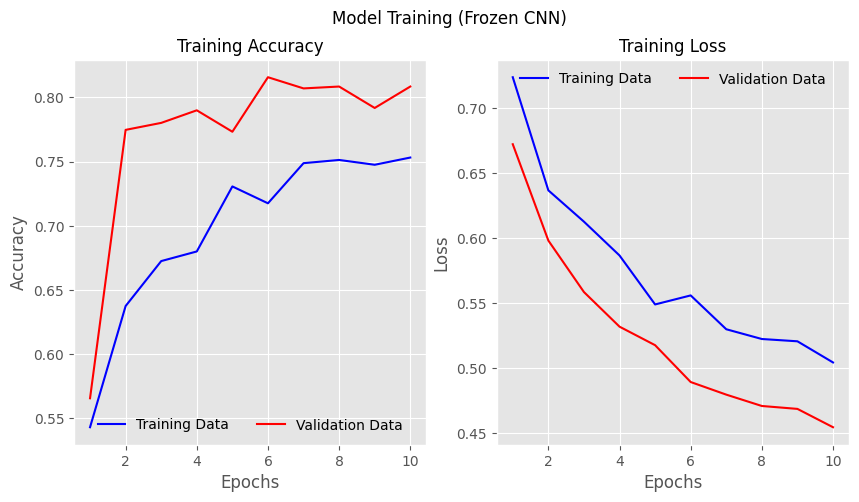

In [57]:
# Plot performance
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
fig.suptitle("Model Training (Frozen CNN)", fontsize=12)
max_epoch = len(history_01.history['accuracy'])+1
epochs_list = list(range(1, max_epoch))

ax1.plot(epochs_list, history_01.history['accuracy'], color='b', linestyle='-', label='Training Data')
ax1.plot(epochs_list, history_01.history['val_accuracy'], color='r', linestyle='-', label='Validation Data')
ax1.set_title('Training Accuracy', fontsize=12)
ax1.set_xlabel('Epochs', fontsize=12)
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.legend(frameon=False, loc='lower center', ncol=2)

ax2.plot(epochs_list, history_01.history['loss'], color='b', linestyle='-', label='Training Data')
ax2.plot(epochs_list, history_01.history['val_loss'], color='r', linestyle='-', label='Validation Data')
ax2.set_title('Training Loss', fontsize=12)
ax2.set_xlabel('Epochs', fontsize=12)
ax2.set_ylabel('Loss', fontsize=12)
ax2.legend(frameon=False, loc='upper center', ncol=2)
plt.savefig("outputs/malaria_training_frozencnn.jpeg", format='jpeg', dpi=400, bbox_inches='tight')

In [58]:
# save model
if not os.path.isdir('model_weights/'):
    os.mkdir('model_weights/')
model_01.save_weights(filepath='model_weights/vgg19_model_01.h5', overwrite=True)

In [59]:
# Resize test images similar to the train data
test_generator = test_datagen.flow_from_directory(test_dir,
                                                  batch_size=1,
                                                  target_size=(128, 128),
                                                  class_mode='categorical',
                                                  shuffle=False,
                                                  seed=42,
                                                  color_mode='rgb')

Found 2756 images belonging to 2 classes.


In [60]:
# Load the saved model
model_01.load_weights('model_weights/vgg19_model_01.h5')
# Evaluate the model on the hold out validation and test datasets

# Evaluate the model on batches of validation and testing data
vgg_val_eval_01 = model_01.evaluate(valid_generator)
vgg_test_eval_01 = model_01.evaluate(test_generator)

print('Validation loss:     {0:.4f}'.format(vgg_val_eval_01[0]))
print('Validation accuracy: {0:.4f}'.format(vgg_val_eval_01[1]))
print('Test loss:           {0:.4f}'.format(vgg_test_eval_01[0]))
print('Test accuracy:       {0:.4f}'.format(vgg_test_eval_01[1]))

2756/2756 [==============================] - 25s 9ms/step - loss: 0.4520 - accuracy: 0.7990
Validation loss:     0.4545
Validation accuracy: 0.8084
Test loss:           0.4520
Test accuracy:       0.7990


In [61]:
filenames = test_generator.filenames
nb_samples = len(filenames)
vgg_predictions_01 = model_01.predict(test_generator,
                                      steps = nb_samples,
                                      verbose=1)
vgg_pred_labels_01= np.argmax(vgg_predictions_01, axis=1)

2756/2756 [==============================] - 22s 8ms/step


In [62]:
# Classification Report
print(classification_report(test_generator.classes, vgg_pred_labels_01,
                            target_names=['healthy', 'infected']))
vgg_conf_mat_01 = pd.DataFrame(confusion_matrix(test_generator.classes, vgg_pred_labels_01),
                        index=['healthy', 'infected'],
                        columns=['healthy', 'infected'])

              precision    recall  f1-score   support

     healthy       0.73      0.96      0.83      1378
    infected       0.94      0.64      0.76      1378

    accuracy                           0.80      2756
   macro avg       0.83      0.80      0.79      2756
weighted avg       0.83      0.80      0.79      2756



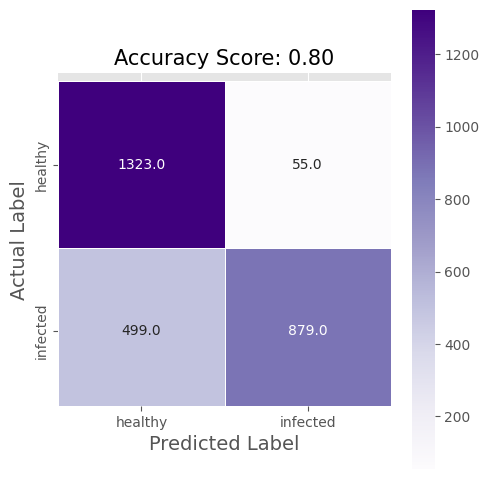

In [63]:
fig, ax = plt.subplots(figsize=(5,5))
#plt.figure(figsize=(9,9))
sns.heatmap(vgg_conf_mat_01, annot=True, fmt=".1f", linewidths=0.5, square=True, cmap='Purples')
ax.set_ylabel("Actual Label", fontsize=14)
ax.set_xlabel("Predicted Label", fontsize=14)
all_sample_title="Accuracy Score: {0:.2f}".format(vgg_test_eval_01[1])
ax.set_title(all_sample_title, size=15)
ax.set_ylim(len(vgg_conf_mat_01)-0.05, -0.05)
plt.tight_layout()

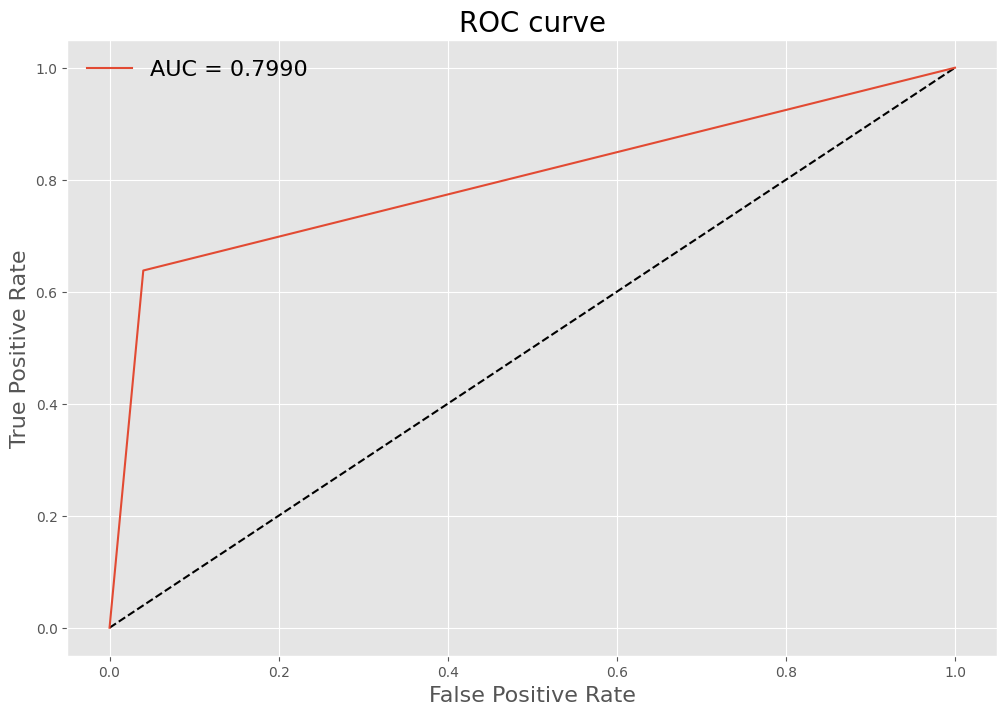

In [64]:
# AUC Curve
false_positive_rate, true_positive_rate, threshold = roc_curve(test_generator.classes, vgg_pred_labels_01)
area_under_curve = auc(false_positive_rate, true_positive_rate)

# Plot AUC Curve
fig, ax = plt.subplots(figsize=(12,8))
ax.plot([0,1], [0,1], 'k--')
ax.plot(false_positive_rate, true_positive_rate, label='AUC = {:.4f}'.format(area_under_curve))
ax.set_xlabel('False Positive Rate', fontsize=16)
ax.set_ylabel('True Positive Rate', fontsize=16)
ax.set_title("ROC curve", fontsize=20)
ax.legend(frameon=False, loc='best', ncol=1, fontsize=16)

# Incremental unfreezing and fine-tuning

In [65]:
base_model = VGG19(include_top=False, input_shape=(128,128,3))
base_model_layer_names = [layer.name for layer in base_model.layers]
base_model_layer_names

x = base_model.output

flat=Flatten()(x)

class_1 = Dense(4608, activation='relu')(flat)
drop_out = Dropout(0.2)(class_1)
class_2 = Dense(1152, activation='relu')(drop_out)
output = Dense(2, activation='softmax')(class_2)

model_02 = Model(base_model.inputs, output)
model_02.load_weights('model_weights/vgg19_model_01.h5')

set_trainable = False
for layer in base_model.layers:
    if layer.name in ['block5_conv4', 'block5_conv3']:
        set_trainable=True
    if set_trainable:
        layer.trainable=True
    else:
        layer.trainable=False

print(model_02.summary())

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0   

In [67]:
sgd = tf.keras.optimizers.legacy.SGD(learning_rate=0.001, decay=1e-6, momentum=0.9, nesterov=True)
#model_02 = Model(base_model.inputs, output)
model_02.compile(optimizer=sgd,
                loss='categorical_crossentropy',
                metrics=['accuracy'])

In [68]:
history_02 = model_02.fit(train_generator,
                          steps_per_epoch=10,
                          epochs=10,
                          callbacks = [es, cp, lrr],
                          validation_data = valid_generator)

Epoch 1/10
10/10 [==============================] - ETA: 0s - loss: 0.6845 - accuracy: 0.6500
Epoch 1: val_loss did not improve from 0.45449
10/10 [==============================] - 12s 1s/step - loss: 0.6845 - accuracy: 0.6500 - val_loss: 0.4731 - val_accuracy: 0.7565 - lr: 0.0010
Epoch 2/10
10/10 [==============================] - ETA: 0s - loss: 0.6785 - accuracy: 0.6281
Epoch 2: val_loss improved from 0.45449 to 0.42469, saving model to models/malaria.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


10/10 [==============================] - 10s 1s/step - loss: 0.6785 - accuracy: 0.6281 - val_loss: 0.4247 - val_accuracy: 0.7957 - lr: 0.0010
Epoch 3/10
10/10 [==============================] - ETA: 0s - loss: 0.5468 - accuracy: 0.7281
Epoch 3: val_loss improved from 0.42469 to 0.36855, saving model to models/malaria.h5
10/10 [==============================] - 14s 2s/step - loss: 0.5468 - accuracy: 0.7281 - val_loss: 0.3685 - val_accuracy: 0.8422 - lr: 0.0010
Epoch 4/10
10/10 [==============================] - ETA: 0s - loss: 0.4475 - accuracy: 0.8062
Epoch 4: val_loss improved from 0.36855 to 0.33041, saving model to models/malaria.h5
10/10 [==============================] - 8s 905ms/step - loss: 0.4475 - accuracy: 0.8062 - val_loss: 0.3304 - val_accuracy: 0.8687 - lr: 0.0010
Epoch 5/10
10/10 [==============================] - ETA: 0s - loss: 0.4529 - accuracy: 0.7875
Epoch 5: val_loss improved from 0.33041 to 0.30716, saving model to models/malaria.h5
10/10 [=========================

In [69]:
# save model
if not os.path.isdir('model_weights/'):
    os.mkdir('model_weights/')
model_02.save_weights(filepath='model_weights/vgg19_model_02.h5', overwrite=True)

# Evaluating the model

2756/2756 [==============================] - 25s 9ms/step - loss: 0.3838 - accuracy: 0.8193
Validation loss:     0.3647768497467041
Validation accuracy: 0.8334543108940125
Test loss:           0.3837725520133972
Test accuracy:       0.8193033337593079
2756/2756 [==============================] - 20s 7ms/step
              precision    recall  f1-score   support

     healthy       0.74      0.98      0.84      1378
    infected       0.98      0.66      0.78      1378

    accuracy                           0.82      2756
   macro avg       0.86      0.82      0.81      2756
weighted avg       0.86      0.82      0.81      2756



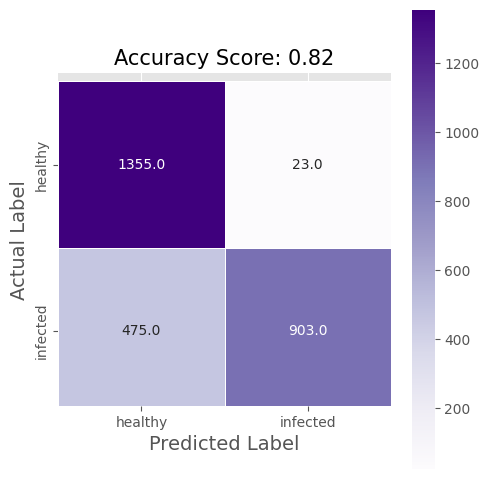

In [70]:
# Load the saved model
model_02.load_weights('model_weights/vgg19_model_02.h5')
# Evaluate the model on the hold out validation and test datasets

vgg_val_eval_02 = model_02.evaluate(valid_generator)
vgg_test_eval_02 = model_02.evaluate(test_generator)

print('Validation loss:     {}'.format(vgg_val_eval_02[0]))
print('Validation accuracy: {}'.format(vgg_val_eval_02[1]))
print('Test loss:           {}'.format(vgg_test_eval_02[0]))
print('Test accuracy:       {}'.format(vgg_test_eval_02[1]))


filenames = test_generator.filenames
nb_samples = len(filenames)
vgg_predictions_02 = model_02.predict(test_generator,
                                                steps = nb_samples,
                                                verbose=1)
vgg_pred_labels_02 = np.argmax(vgg_predictions_02, axis=1)


# Classification Report
print(classification_report(test_generator.classes, vgg_pred_labels_02,
                            target_names=['healthy', 'infected']))
vgg_conf_mat_02 = pd.DataFrame(confusion_matrix(test_generator.classes, vgg_pred_labels_02),
                        index=['healthy', 'infected'],
                        columns=['healthy', 'infected'])


fig, ax = plt.subplots(figsize=(5,5))

sns.heatmap(vgg_conf_mat_02, annot=True, fmt=".1f", linewidths=0.5, square=True, cmap='Purples')
ax.set_ylabel("Actual Label", fontsize=14)
ax.set_xlabel("Predicted Label", fontsize=14)
all_sample_title="Accuracy Score: {0:.2f}".format(vgg_test_eval_02[1])
ax.set_title(all_sample_title, size=15)
ax.set_ylim(len(vgg_conf_mat_02)-0.05, -0.05)
plt.tight_layout()

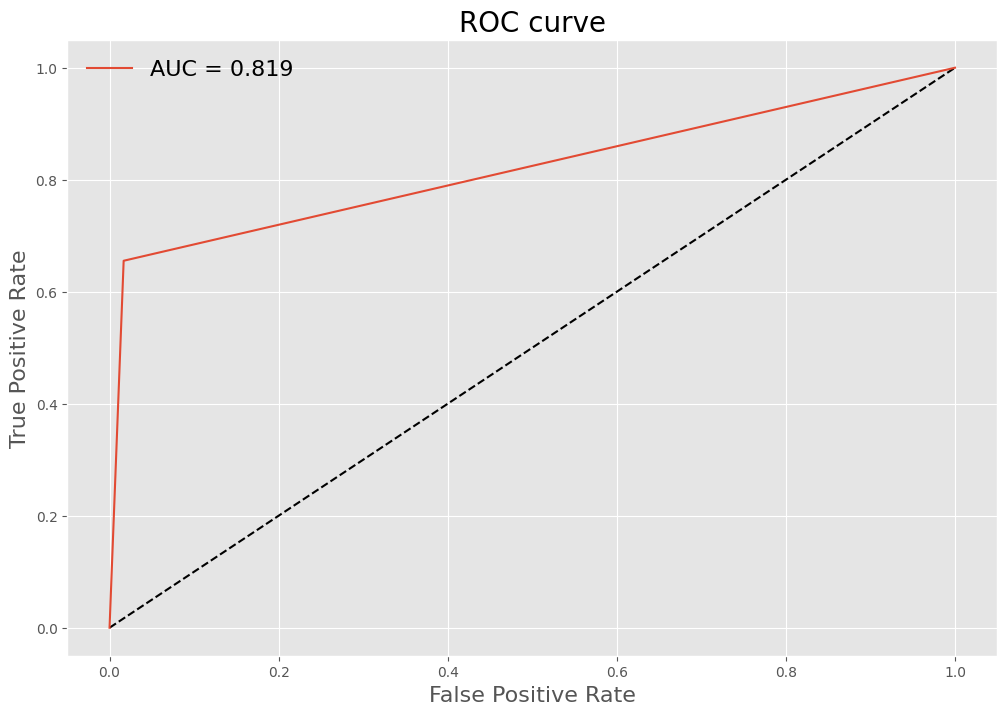

In [71]:
# AUC Curve
false_positive_rate, true_positive_rate, threshold = roc_curve(test_generator.classes, vgg_pred_labels_02)
area_under_curve = auc(false_positive_rate, true_positive_rate)

# Plot AUC Curve
fig, ax = plt.subplots(figsize=(12,8))
ax.plot([0,1], [0,1], 'k--')
ax.plot(false_positive_rate, true_positive_rate, label='AUC = {:.3f}'.format(area_under_curve))
ax.set_xlabel('False Positive Rate', fontsize=16)
ax.set_ylabel('True Positive Rate', fontsize=16)
ax.set_title("ROC curve", fontsize=20)
ax.legend(frameon=False, loc='best', ncol=1, fontsize=16)

# Unfreezing and fine-tuning the entire network

In [72]:
# Build the network
base_model = VGG19(include_top=False, input_shape=(128,128,3))
x = base_model.output
flat=Flatten()(x)
class_1 = Dense(4608, activation='relu')(flat)
drop_out = Dropout(0.2)(class_1)
class_2 = Dense(1152, activation='relu')(drop_out)
output = Dense(2, activation='softmax')(class_2)
model_03 = Model(base_model.inputs, output)

# Load weights
model_03.load_weights('model_weights/vgg19_model_02.h5')

sgd = tf.keras.optimizers.legacy.SGD(learning_rate=0.0001, decay=1e-6, momentum=0.9, nesterov=True)
# Compile the model
model_03.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

In [73]:
history_03 = model_03.fit(train_generator,
                          steps_per_epoch=100,
                          epochs=35,
                          callbacks = [es, cp, lrr],
                          validation_data = valid_generator)

Epoch 1/35
100/100 [==============================] - ETA: 0s - loss: 0.3475 - accuracy: 0.8541
Epoch 1: val_loss improved from 0.27006 to 0.18519, saving model to models/malaria.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


100/100 [==============================] - 48s 412ms/step - loss: 0.3475 - accuracy: 0.8541 - val_loss: 0.1852 - val_accuracy: 0.9358 - lr: 1.0000e-04
Epoch 2/35
100/100 [==============================] - ETA: 0s - loss: 0.3059 - accuracy: 0.8766
Epoch 2: val_loss improved from 0.18519 to 0.16656, saving model to models/malaria.h5
100/100 [==============================] - 37s 365ms/step - loss: 0.3059 - accuracy: 0.8766 - val_loss: 0.1666 - val_accuracy: 0.9419 - lr: 1.0000e-04
Epoch 3/35
100/100 [==============================] - ETA: 0s - loss: 0.3125 - accuracy: 0.8772
Epoch 3: val_loss improved from 0.16656 to 0.16141, saving model to models/malaria.h5
100/100 [==============================] - 37s 371ms/step - loss: 0.3125 - accuracy: 0.8772 - val_loss: 0.1614 - val_accuracy: 0.9467 - lr: 1.0000e-04
Epoch 4/35
100/100 [==============================] - ETA: 0s - loss: 0.2931 - accuracy: 0.8869
Epoch 4: val_loss did not improve from 0.16141
100/100 [==============================]

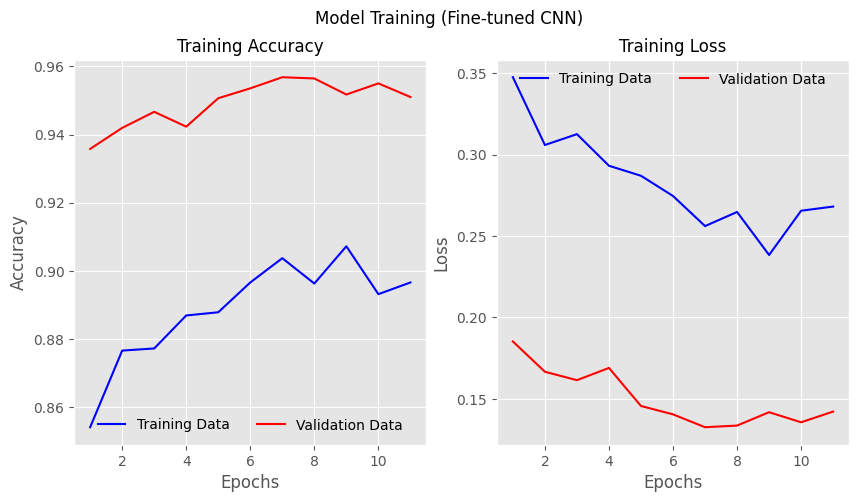

In [74]:
# Plot performance
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
fig.suptitle("Model Training (Fine-tuned CNN)", fontsize=12)
max_epoch = len(history_03.history['accuracy'])+1
epochs_list = list(range(1, max_epoch))

ax1.plot(epochs_list, history_03.history['accuracy'], color='b', linestyle='-', label='Training Data')
ax1.plot(epochs_list, history_03.history['val_accuracy'], color='r', linestyle='-', label='Validation Data')
ax1.set_title('Training Accuracy', fontsize=12)
ax1.set_xlabel('Epochs', fontsize=12)
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.legend(frameon=False, loc='lower center', ncol=2)

ax2.plot(epochs_list, history_03.history['loss'], color='b', linestyle='-', label='Training Data')
ax2.plot(epochs_list, history_03.history['val_loss'], color='r', linestyle='-', label='Validation Data')
ax2.set_title('Training Loss', fontsize=12)
ax2.set_xlabel('Epochs', fontsize=12)
ax2.set_ylabel('Loss', fontsize=12)
ax2.legend(frameon=False, loc='upper center', ncol=2)
plt.savefig("outputs/malaria_training_finetunedcnn.jpeg", format='jpeg', dpi=400, bbox_inches='tight')

In [75]:
# save model
if not os.path.isdir('model_weights/'):
    os.mkdir('model_weights/')
model_03.save_weights(filepath='model_weights/vgg_unfrozen.h5', overwrite=True)

# Evaluating the model

2756/2756 [==============================] - 24s 9ms/step - loss: 0.1519 - accuracy: 0.9463
Validation loss     :0.1421
Validation accuracy :0.9510
Test loss           :0.1519
Test accuracy       :0.9463
2756/2756 [==============================] - 20s 7ms/step
              precision    recall  f1-score   support

     healthy       0.91      0.99      0.95      1378
    infected       0.99      0.91      0.94      1378

    accuracy                           0.95      2756
   macro avg       0.95      0.95      0.95      2756
weighted avg       0.95      0.95      0.95      2756



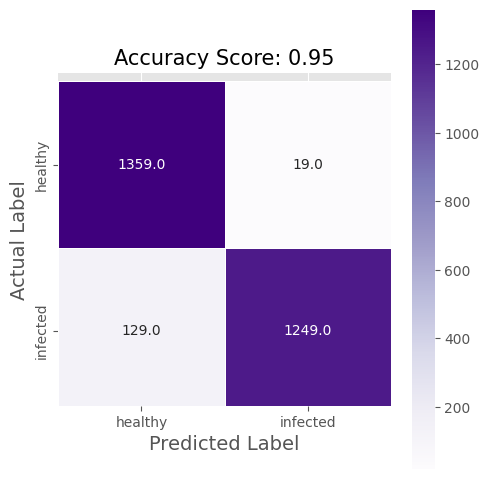

In [76]:
# Load the saved model
model_03.load_weights('model_weights/vgg_unfrozen.h5')
# Evaluate the model on the hold out validation and test datasets

vgg_val_eval_03 = model_03.evaluate(valid_generator)
vgg_test_eval_03 = model_03.evaluate(test_generator)

print('Validation loss     :{0:.4f}'.format(vgg_val_eval_03[0]))
print('Validation accuracy :{0:.4f}'.format(vgg_val_eval_03[1]))
print('Test loss           :{0:.4f}'.format(vgg_test_eval_03[0]))
print('Test accuracy       :{0:.4f}'.format(vgg_test_eval_03[1]))


filenames = test_generator.filenames
nb_samples = len(filenames)
vgg_predictions_03 = model_03.predict(test_generator,
                                      steps = nb_samples,
                                      verbose=1)
vgg_pred_labels_03 = np.argmax(vgg_predictions_03, axis=1)


# Classification Report
print(classification_report(test_generator.classes, vgg_pred_labels_03,
                            target_names=['healthy', 'infected']))
vgg_conf_mat_03 = pd.DataFrame(confusion_matrix(test_generator.classes, vgg_pred_labels_03),
                        index=['healthy', 'infected'],
                        columns=['healthy', 'infected'])


fig, ax = plt.subplots(figsize=(5,5))

sns.heatmap(vgg_conf_mat_03, annot=True, fmt=".1f", linewidths=0.5, square=True, cmap='Purples')
ax.set_ylabel("Actual Label", fontsize=14)
ax.set_xlabel("Predicted Label", fontsize=14)
all_sample_title="Accuracy Score: {0:.2f}".format(vgg_test_eval_03[1])
ax.set_title(all_sample_title, size=15)
ax.set_ylim(len(vgg_conf_mat_03)-0.05, -0.05)
plt.tight_layout()

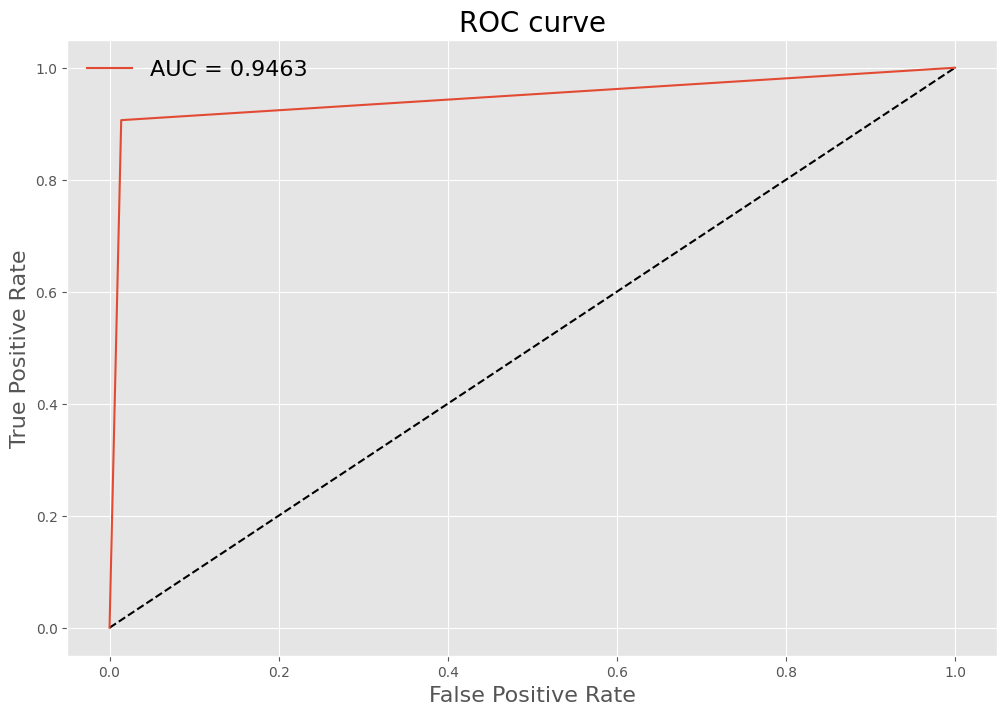

In [77]:
# AUC Curve
false_positive_rate, true_positive_rate, threshold = roc_curve(test_generator.classes, vgg_pred_labels_03)
area_under_curve = auc(false_positive_rate, true_positive_rate)

# Plot AUC Curve
fig, ax = plt.subplots(figsize=(12,8))
ax.plot([0,1], [0,1], 'k--')
ax.plot(false_positive_rate, true_positive_rate, label='AUC = {:.4f}'.format(area_under_curve))
ax.set_xlabel('False Positive Rate', fontsize=16)
ax.set_ylabel('True Positive Rate', fontsize=16)
ax.set_title("ROC curve", fontsize=20)
ax.legend(frameon=False, loc='best', ncol=1, fontsize=16)

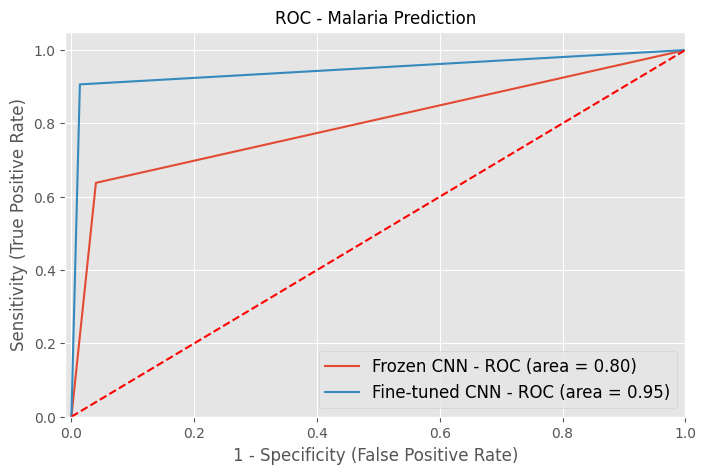

In [78]:
from sklearn import metrics
plt.figure(figsize=(8,5))
models = [
{
    'label': 'Frozen CNN',
    'model': model_01,
    'roc': vgg_pred_labels_01,
},
{
    'label': 'Fine-tuned CNN',
    'model': model_03,
    'roc': vgg_pred_labels_03,
}
]
for m in models:
    model = m['model']
    false_positive_rate, true_positive_rate, threshold = roc_curve(test_generator.classes, m['roc'])
    area_under_curve = auc(false_positive_rate, true_positive_rate)
    plt.plot(false_positive_rate, true_positive_rate, label='%s - ROC (area = %0.2f)' % (m['label'], area_under_curve))

plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1 - Specificity (False Positive Rate)', fontsize=12)
plt.ylabel('Sensitivity (True Positive Rate)', fontsize=12)
plt.title('ROC - Malaria Prediction', fontsize=12)
plt.legend(loc="lower right", fontsize=12)
plt.savefig("outputs/roc_malaria.jpeg", format='jpeg', dpi=400, bbox_inches='tight')
plt.show()

[79.86, 95.65]
[79.86, 95.65]


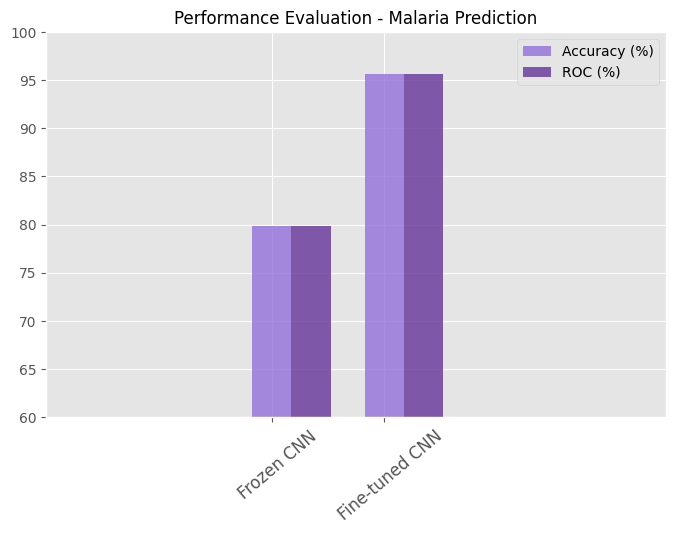

In [79]:
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt
models = [
{
    'label': 'Frozen CNN',
    'model': model_01,
},
{
    'label': 'Fine-tuned CNN',
    'model': model_03,
}
]

means_roc = [79.86, 95.65]
means_accuracy = [79.86, 95.65]
means_loss = [45.57, 12.14]

print(means_accuracy)
print(means_roc)

# data to plot
n_groups = 2
means_loss = tuple(means_loss)
means_accuracy = tuple(means_accuracy)
# means_roc = tuple(means_roc)

# create plot
fig, ax = plt.subplots(figsize=(8,5))
index = np.arange(n_groups)
bar_width = 0.35
opacity = 0.8

# rects1 = plt.bar(index, means_loss, bar_width,
# alpha=opacity,
# color='pink',
# label='Categorical crossentropy Loss (%)')

rects2 = plt.bar(index, means_accuracy, bar_width,
alpha=opacity,
color='mediumpurple',
label='Accuracy (%)')

rects3 = plt.bar(index + bar_width, means_roc, bar_width,
alpha=opacity,
color='rebeccapurple',
label='ROC (%)')

plt.xlim([-2, 3.5])
plt.ylim([60, 100])

plt.title('Performance Evaluation - Malaria Prediction', fontsize=12)
plt.xticks(index, ('   Frozen CNN', '   Fine-tuned CNN'), rotation=40, ha='center', fontsize=12)
plt.legend(loc="upper right", fontsize=10)
# plt.legend(bbox_to_anchor =(1, 0.6), fontsize=12)
plt.savefig("outputs/PE_malaria.jpeg", format='jpeg', dpi=400, bbox_inches='tight')
plt.show()

[45.57, 12.14]


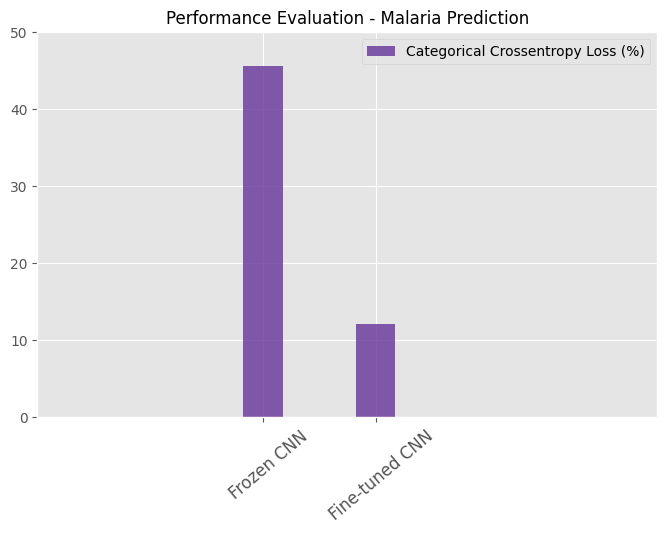

In [80]:
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt
models = [
{
    'label': 'Frozen CNN',
    'model': model_01,
},
{
    'label': 'Fine-tuned CNN',
    'model': model_03,
}
]

means_loss = [45.57, 12.14]

print(means_loss)

# data to plot
n_groups = 2
means_roc = tuple(means_roc)

# create plot
fig, ax = plt.subplots(figsize=(8,5))
index = np.arange(n_groups)
bar_width = 0.35
opacity = 0.8

rects1 = plt.bar(index, means_loss, bar_width,
alpha=opacity,
color='rebeccapurple',
label='Categorical Crossentropy Loss (%)')

plt.xlim([-2, 3.5])
plt.ylim([0, 50])

plt.title('Performance Evaluation - Malaria Prediction', fontsize=12)
plt.xticks(index, ('   Frozen CNN', '   Fine-tuned CNN'), rotation=40, ha='center', fontsize=12)
plt.legend(loc="upper right", fontsize=10)
# plt.legend(bbox_to_anchor =(1, 0.6), fontsize=12)
plt.savefig("outputs/PE_malaria2.jpeg", format='jpeg', dpi=400, bbox_inches='tight')
plt.show()

## Prediction results for 10 randomly selected images

In [81]:
test_images = [img for img in random.sample(infected_test_fpaths, 5)]
test_images.extend([img for img in random.sample(healthy_test_fpaths, 5)])

1/1 [==============================] - 0s 31ms/step


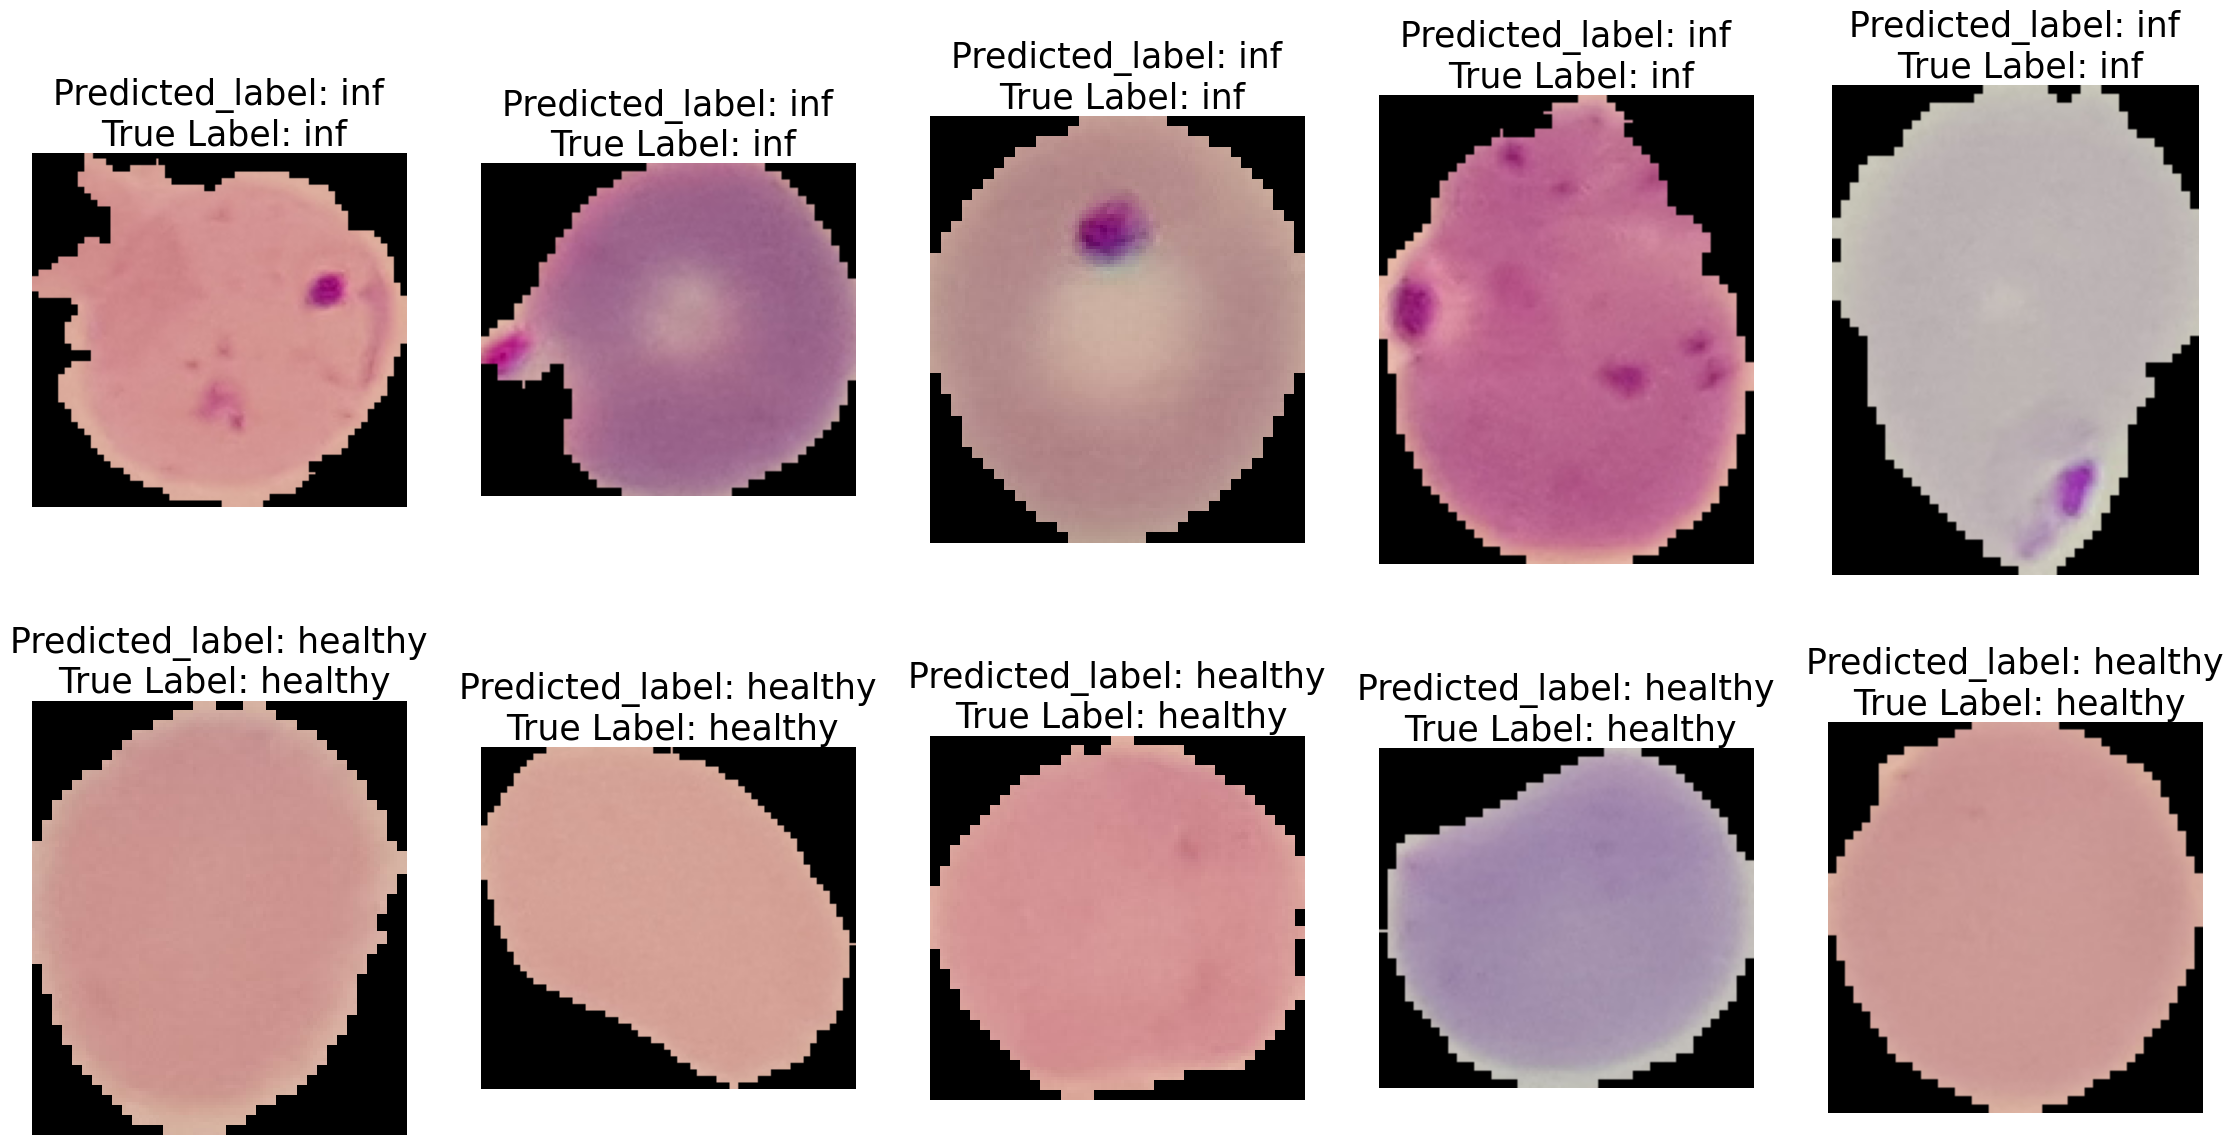

In [85]:
from keras.preprocessing.image import ImageDataGenerator
true_labels = []
predicted_labels = []
fig = plt.figure(figsize=(28,14))
columns=5
rows=2
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    true_label = true_labels.append(test_images[i-1].split('/')[2])
    img = mpimg.imread(test_images[i-1])
    plt.imshow(img)
    plt.axis('off')
    img = tf.keras.utils.load_img(test_images[i-1], target_size=(128,128))
    img = tf.keras.utils.img_to_array(img)
    img = np.expand_dims(img, axis = 0)
    prediction = model_03.predict(img)
    predicted_label = np.argmax(prediction)
    plt.title('Predicted_label: {}\n True Label: {}'.format(class_names[predicted_label], true_labels[i-1]), fontsize=25)
plt.savefig("outputs/malaria_predictions.jpeg", format='jpeg', dpi=400, bbox_inches='tight')
plt.show()